# mini-J-PAS

This notebook is an application of the xlensing code over several surveys to investigate the relationship between cluster mass concentration and observables that may relate to mass accretion age.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pyplot.style.use('ggplot')
np.set_printoptions(linewidth=400)

In [3]:


from getdist import plots, MCSamples
from astropy.table import Table

import os
import pickle

import xlensing

import emcee
import time

Lookup table loaded!


## Fetching Data

mini-J-PAS

In [4]:
JPAS_DIR = os.path.expanduser("~/Data/data_minijpas")
JPAS_PZWAV = "pzwav_SNR3.fits"

In [5]:
clusters = Table.read(os.path.join(JPAS_DIR,JPAS_PZWAV))
len(clusters)

661

In [6]:
def scatter_hist(X,Y,labels):
  figure(figsize(10,10))
  subplot(221)
  hist(X)
  subplot(223)
  scatter(X,Y)
  xlabel(labels[0])
  ylabel(labels[1])
  subplot(224)
  hist(Y,orientation='horizontal') 

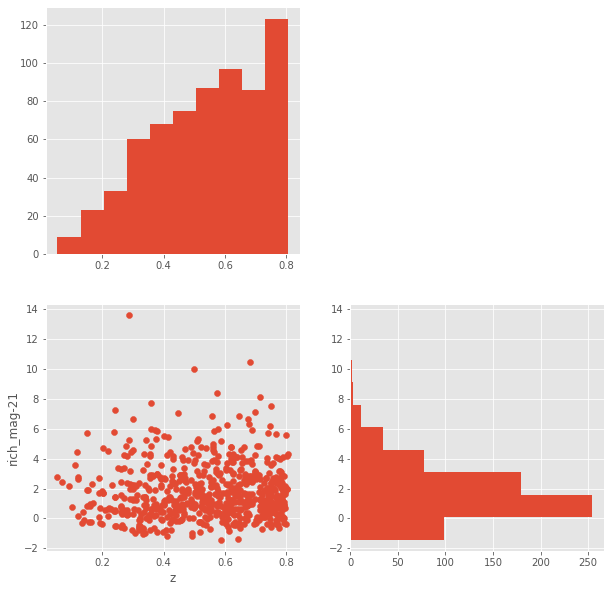

In [7]:
scatter_hist(clusters['z'],clusters['rich_mag-21'],['z','rich_mag-21'])

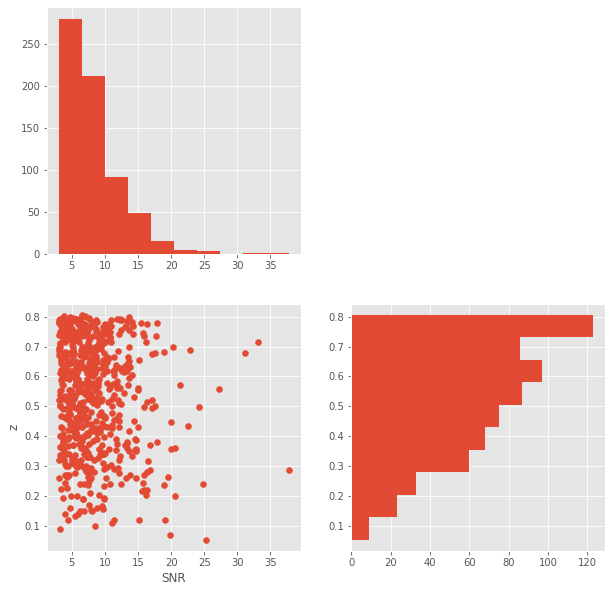

In [8]:
X, Y = "SNR", "z"
labels = [X,Y]
X = clusters[X]
Y = clusters[Y]
scatter_hist(X,Y,labels)

In [9]:
clusters['INDEX'] = range(len(clusters))
goodclusters = clusters[clusters["SNR"]>11.5]
print(len(goodclusters))

120


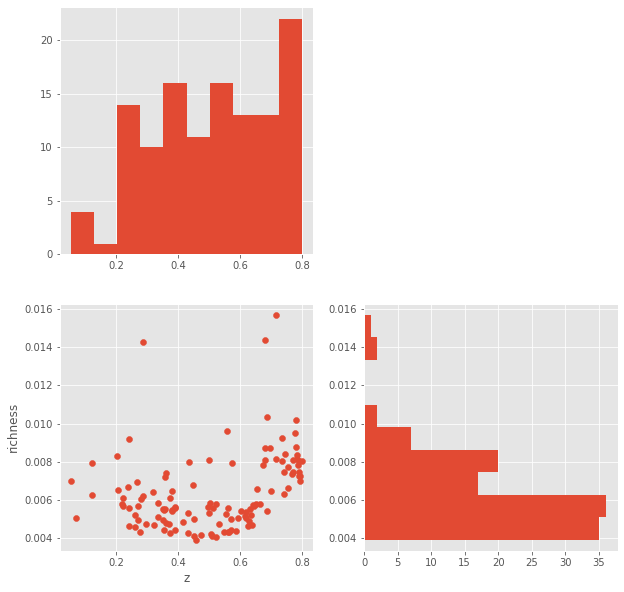

In [10]:
X, Y = "z", "richness"
labels = [X,Y]
X = goodclusters[X]
Y = goodclusters[Y]
scatter_hist(X,Y,labels)

In [11]:
medianz=np.median(goodclusters['z'])
lowzclusters =goodclusters[goodclusters['z']<medianz]
highzclusters =goodclusters[goodclusters['z']>medianz]

In [12]:
median_rich_lowz = np.median(lowzclusters['rich_mag-21'])
lowzclusters_rich = lowzclusters[lowzclusters['rich_mag-21']>median_rich_lowz]  
lowzclusters_poor = lowzclusters[lowzclusters['rich_mag-21']<median_rich_lowz]

In [13]:
median_rich_highz = np.median(highzclusters['rich_mag-21'])
highzclusters_rich = lowzclusters[highzclusters['rich_mag-21']>median_rich_highz]  
highzclusters_poor = lowzclusters[highzclusters['rich_mag-21']<median_rich_highz]

In [14]:
CFHT_SOURCES = "CFHTLens.tsv"

In [15]:
sourcescfht=Table.read(os.path.join(JPAS_DIR,CFHT_SOURCES),format='ascii')

In [16]:
sourcescfht

ALPHA_J2000,DELTA_J2000,e1,e2,weight,Z_B,m
float64,float64,float64,float64,float64,float64,float64
214.5166955,53.10332322,0.3108,-0.3881,10.2152,0.12,-0.0463996
214.5899414,53.10341224,0.2553,0.2058,14.4933,0.36,-0.0160982
214.6617848,53.10337401,0.3077,0.4934,13.0818,0.54,-0.0120586
214.2610387,53.10331905,0.5763,0.3568,14.6419,0.34,-0.00115861
214.3607598,53.10345095,-0.3274,0.5616,14.2534,0.49,-0.00383721
214.3515406,53.10357204,-0.2211,-0.0391,10.9649,0.14,-0.0889275
214.3675137,53.10358701,-0.0001,0.0255,15.3949,0.79,-0.00118332
214.3148936,53.10354226,-0.09,0.1818,8.8553,1.05,-0.0935789
214.5357966,53.10355466,-0.0696,-0.1851,14.8614,1.09,-0.00993284


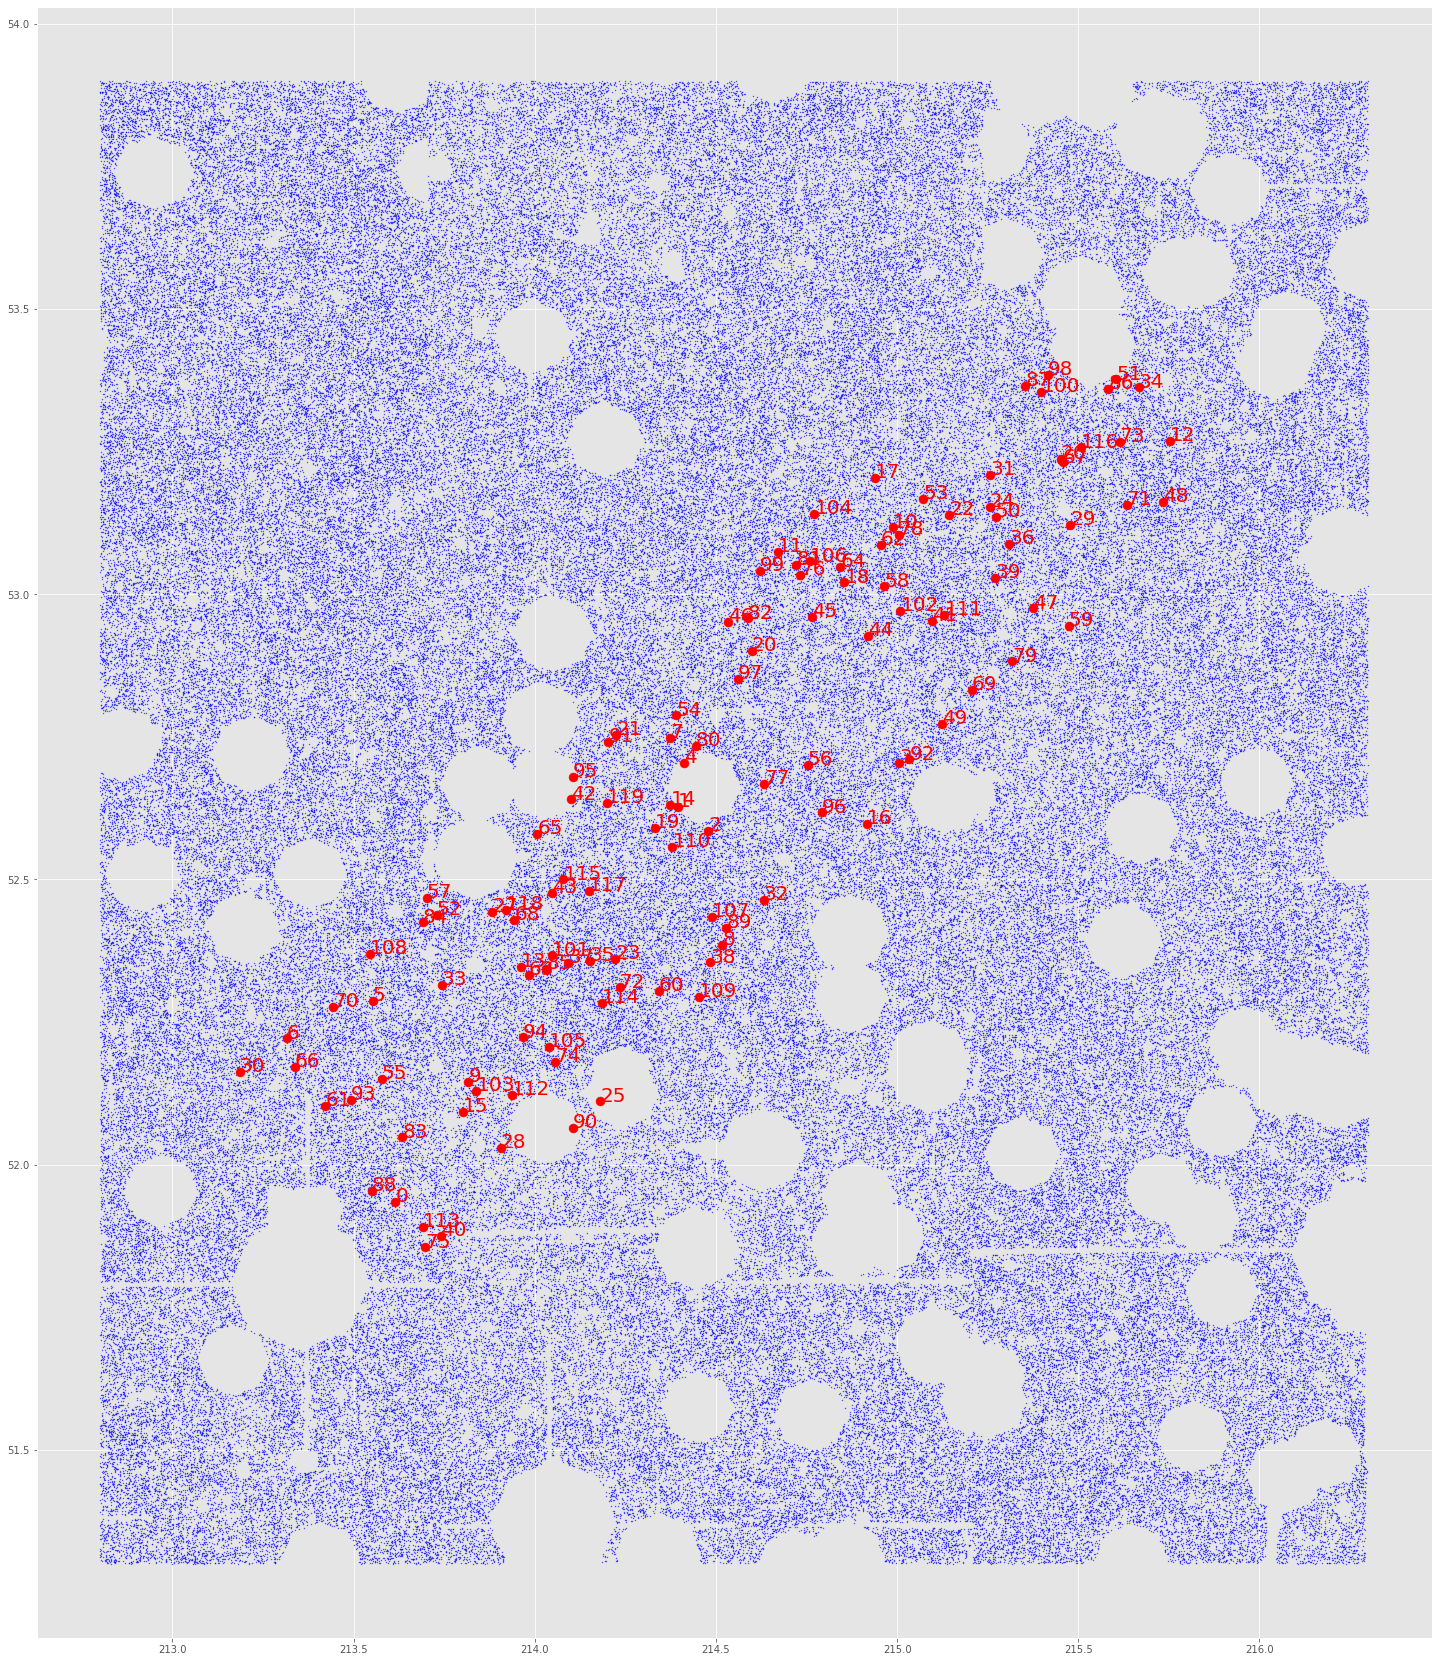

In [17]:
plt.figure(figsize=(2.5*10,3*10))
plt.scatter(sourcescfht['ALPHA_J2000'],sourcescfht['DELTA_J2000'],s=1,alpha=0.5,color='blue')
k=0
for cluster in goodclusters:
    plt.scatter(cluster['RA'],cluster['DEC'],s=80,color='red')
    #print(cluster['RA'],cluster['DEC'])
    
    plt.text(cluster['RA'],cluster['DEC'],"{}".format(k),fontsize=20, color='red')
    k=k+1
plt.savefig('mini_jpas_cluster_lensing.png',bbox_inches='tight')

In [18]:
goodclusters['RA_RAD'] = np.radians(goodclusters['RA'])
goodclusters['DEC_RAD']= np.radians(goodclusters['DEC'])


sr_RA = np.radians(np.array(sourcescfht['ALPHA_J2000']))
sr_DEC= np.radians(np.array(sourcescfht['DELTA_J2000']))
sr_z  = np.array(sourcescfht['Z_B'])
sr_E1 = np.array(sourcescfht['e1'])
sr_E2 = np.array(sourcescfht['e2'])
sr_W = np.array(sourcescfht['weight'])
sr_M = np.array(sourcescfht['m'])

In [19]:
cl_RA= goodclusters['RA_RAD']
cl_DEC= goodclusters['DEC_RAD']
cl_z= clusters['z']
cl = np.array([cl_RA,cl_DEC,cl_z]).T

<ipython-input-19-acc4901e75f1>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cl = np.array([cl_RA,cl_DEC,cl_z]).T


Getting lensing signal for all clusters:

In [20]:
#let's use multiprocessing
from multiprocessing import Pool, freeze_support, cpu_count
from functools import partial

# you can use whatever, but your machine core count is usually a good choice (although maybe not the best)
pool = Pool(8) 


#We get a partial function with a constant galaxy catalogue to iterate with clusters.
survey_lensing = partial(xlensing.data.cluster_lensing,sources=(sr_RA, sr_DEC, sr_z, sr_E1, sr_E2, sr_W,sr_M),radius=10.)

In [21]:
#Make a list of clusters to get lensing data
clz = zip(cl_RA,cl_DEC,cl_z)
clzlist = [x for x in clz]

In [22]:
results = pool.map(survey_lensing, clzlist)

### Stacking CS82 Data

In [23]:
radii = np.logspace(-.8,.8,6)
N = len(radii)
bins_lims = np.logspace(np.log10(radii[0])+(np.log10(radii[0])-np.log10(radii[1]))/2,
                        np.log10(radii[N-1])-(np.log10(radii[0])-np.log10(radii[1]))/2,N+1)
bins_lims = np.array([[bins_lims[i],bins_lims[i+1]] for i in range(N)])
bins_lims #in Mpc/h

array([[0.10964782, 0.22908677],
       [0.22908677, 0.47863009],
       [0.47863009, 1.        ],
       [1.        , 2.08929613],
       [2.08929613, 4.36515832],
       [4.36515832, 9.12010839]])

In [24]:
stick = [lowzclusters_rich,lowzclusters_poor,highzclusters_rich,highzclusters_poor]

In [ ]:
Nboot=500
stick_results = []
for stake in stick:
    t = time.time()
    clusterbkgs = []
    for index in stake['INDEX']:
        Sigma_crit = np.array(results[index]['Critical Density'])
        e_t = np.array(results[index]['Tangential Shear'])
        e_x = np.array(results[index]['Critical Density'])
        W = np.array(results[index]['Weights'])
        M = np.array(results[index]['Mult. Bias'])
        R = np.array(results[index]['Radial Distance'])
        clusterbkgs.append(np.array([Sigma_crit, e_t, e_x, W, R,M]))
    print(len(clusterbkgs))
    sigmas, sigmas_cov, xigmas, xigmas_cov = xlensing.data.stack(clusterbkgs,bins_lims,Nboot)
    stick_results.append( ( sigmas, sigmas_cov, xigmas, xigmas_cov) )
    print("Done in " + str(time.time()-t) + " seconds.")






30
Total galaxies available per bin:
[935, 4091, 18742, 78707, 321257, 1226007]

Stack of 30 clusters.
Done in 130.0988371372223 seconds.
30
Total galaxies available per bin:
[2299, 11595, 49049, 209599, 684102, 1467887]

Stack of 30 clusters.


In [ ]:
plt.figure(figsize=(7,9))
for stickresult in stick_results:
    plt.scatter(radii,np.array(stickresult[0]), label = 'New Code')
    plt.errorbar(radii,np.array(stickresult[0]),yerr=np.sqrt(np.diag(stickresult[1])),fmt='.')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.savefig('data.pdf')

### Model

In [ ]:
def NFWsimple(theta,Z,radii):
    M200, C200, PCC  = theta
    if C200 <=0:
      C200 = 1e-3
    result = xlensing.model.NFW_shear(M200, C200, Z, PCC, 0.3, 1e10,radii)['Signal']
    return result


Priors:

In [ ]:
M200lo, M200hi = 1e11, 1e15
C200lo, C200hi = 0, 20
PCClo, PCChi = 0., 1
priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)
priorPCC = xlensing.fitting.ln_gaussian_prior_maker(0.75, 0.07,2) ##Zhang et al. 2019
prior = lambda theta : priorM200(theta) + priorC200(theta) + priorPCC(theta)

### MCMC

In [ ]:
ndim, nwalkers, steps = 3, 256, 256
samplestick = []
#for each stack, run MCMC
burnin=round(steps/4.)
for stickresult in stick_results:
    signal = sigmas
    covariance = sigmas_cov
    mean_z = np.average(stake['z'])

    #build data likelihood
    model = lambda theta: NFWsimple(theta,mean_z,radii)
    likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
    posterior = lambda theta : likelihood(theta) +prior(theta)

    #initialise walkers
    pos = []
    for i in range(nwalkers):
        M200 = np.random.uniform(M200lo,M200hi)
        C200 = np.random.uniform(C200lo,C200hi)
        PCC  = np.random.uniform(PCClo,PCChi)
        pos.append(np.array([M200,C200,PCC]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior,threads=16)
    print("Running MCMC...")
    t = time.time()
    sampler.run_mcmc(pos, steps, rstate0=np.random.get_state())
    print("Done in " + str(time.time()-t) + " seconds.")
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samplestick.append(samples)

In [ ]:
for samples in samplestick:
    mvir_tru,conc_tru,pcc_tru= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    print("Mvir: {:.2e}".format(mvir_tru[0]) + " p {:.2e}".format(mvir_tru[1]) + " m {:.2e}".format(mvir_tru[2]))
    print("Conc: {:.2f}".format(conc_tru[0]) + " p {:.2f}".format(conc_tru[1]) + " m {:.2f}".format(conc_tru[2]))
    print("Pcc: {:.2f}".format(pcc_tru[0]) + " p {:.2f}".format(pcc_tru[1]) + " m {:.2f}".format(pcc_tru[2]))

labs =  ["M_{200} [M_\\odot]", "c_{200}","p_{cc}"]

g = plots.getSubplotPlotter()
sample = [MCSamples(samples=samples, names = labs,labels=labs) for samples in samplestick]
g.triangle_plot(sample,filled=True)

In [ ]:
lowz_rich = [7.47e+14, 1.54e+14, 1.74e+14]
lowz_poor = [5.43e+14, 1.04e+14, 8.60e+13]


In [ ]:
val_rich = np.percentile(lowzclusters_rich['rich_mag-21'],[16, 50, 84])
val_poor = np.percentile(lowzclusters_poor['rich_mag-21'],[16, 50, 84])

In [ ]:
scatter ([val_poor[1],val_rich[1]],[lowz_poor[0],lowz_rich[0]],color='red')
#verticals
plot([val_rich[1],val_rich[1]],[lowz_rich[0]-lowz_rich[2],lowz_rich[0]+lowz_rich[1]],color='red')
plot([val_poor[1],val_poor[1]],[lowz_poor[0]-lowz_poor[2],lowz_poor[0]+lowz_poor[1]],color='red')
#horizontals
plot([val_rich[0],val_rich[2]],[lowz_rich[0],lowz_rich[0]],color='red')
plot([val_poor[0],val_poor[2]],[lowz_poor[0],lowz_poor[0]],color='red')
xlabel("richness mag-21")
ylabel("Mass (Msun)")
